### Accessing the google drive from Colab

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
ls

adc.json  drive/  sample_data/


In [0]:
ls 'drive/Colab Notebooks/SFSNet/SkipNet'

checkpoints/                  SkipNet_hdf5.ipynb
img.jpg                       skipNet.ipynb
SfSNet_skipnet_trained.ipynb  skipnet_trained_syn_5gb_relu.ipynb
skipNet_64.ipynb


### Install dependencies

In [0]:
!pip install imutils

  Running setup.py bdist_wheel for imutils ... - done
  Stored in directory: /root/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils


###  Initialization

In [0]:
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import imutils
import skimage
from skimage import io
from skimage import transform
from matplotlib import pyplot as plt

### Load input image with ground truth for Normal, Albedo, Shading and Lighting SH co-ordinates

In [0]:
ls "SyntheticData"

ls: cannot access 'SyntheticData': No such file or directory


In [0]:
!rm -rf 'SyntheticData/data'

In [0]:
# Unzip synthetic data
import zipfile
zip_ref = zipfile.ZipFile('drive/Colab Notebooks/SFSNet/Syn_data_medium.zip', 'r')
zip_ref.extractall('SyntheticData')
zip_ref.close()

In [0]:
image_list = []
normal_list = []
albedo_list = []
mask = []
light = []
cwd = os.getcwd()

# generating list for image, albedo, normal, lighting SH and mask in a similar order
for i in range(0,20):
  folder = str(i+1).zfill(4)
  print(folder)
  path = cwd + '/SyntheticData/data/' + folder + '/'
  addrs = os.walk(path)
  for root, dirs, filename in addrs:
    filename.sort() 
    for file in filename:
      if (file.endswith(".png") and 'face' in file):
        im=io.imread(os.path.join(root, file))
        image_list.append(skimage.transform.resize(im,(128,128)))           
      elif (file.endswith(".png") and 'albedo' in file):
        im=io.imread(os.path.join(root, file))
        albedo_list.append(skimage.transform.resize(im,(128,128)))   
      elif (file.endswith(".png") and 'normal' in file):
        im=io.imread(os.path.join(root, file))
        normal_list.append(skimage.transform.resize(im,(128,128)))
      elif (file.endswith(".png") and 'mask' in file):
        im=io.imread(os.path.join(root, file))
        mask.append(skimage.transform.resize(im,(128,128)))           
      elif (file.endswith(".txt")):
        text = open(os.path.join(root, file),"r") 
        data = text.read()
        data = data.split()
        light.append(data)         


# converting list to array 
image_list = np.array(image_list)
albedo_list = np.array(albedo_list)
normal_list = np.array(normal_list)
light = np.array(light)
mask = np.array(mask)

0001


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020


In [0]:
# converting to flot32 type array
image_list = np.asarray(image_list).astype(np.float32)
normal_list = np.asarray(normal_list).astype(np.float32)
albedo_list = np.asarray(albedo_list).astype(np.float32)
light = np.asarray(light).astype(np.float32)
mask = np.asarray(mask).astype(np.float32)

In [0]:
print(image_list.shape)
print(albedo_list.shape)
print(normal_list.shape)
print(light.shape)
print(mask.shape)

(6000, 128, 128, 3)
(6000, 128, 128, 3)
(6000, 128, 128, 3)
(6000, 27)
(6000, 128, 128, 3)


masking the images

In [0]:
image_list = np.multiply(image_list, mask)

Text(0.5,1,'Normal')

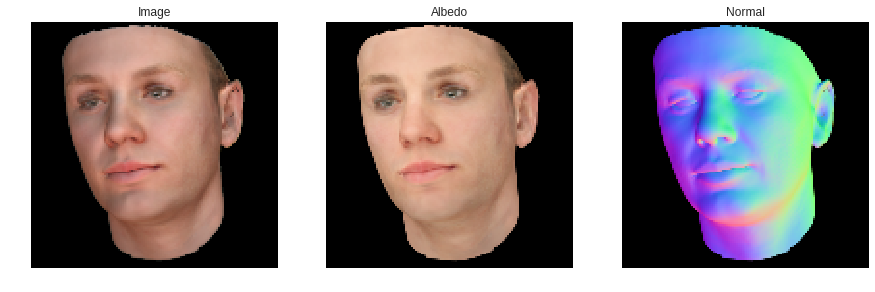

In [0]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,3,figsize=(15,5))

img = image_list[1]
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Image')

img = albedo_list[1]
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Albedo')

img = normal_list[1]
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Normal')


### SkipNet to generate ground truth for CelebA real world images

The synthetic data is stored in TFRecords Format which will be used to train the SkipNet. When the network is trained the real world image will be used to predict normal, albedo and lighting on it.

In [0]:
n_total = image_list.shape[0]
train_min_index = int(n_total * 0)
train_max_index = int(n_total * 0.8)
test_min_index = int((n_total * 0.8))
test_max_index = int(n_total * 1)

train_data = {"images": image_list[:train_max_index], "normals": normal_list[:train_max_index], "albedos": albedo_list[:train_max_index], "lightings": light[:train_max_index]}
test_data = {"images": image_list[test_min_index:], "normals": normal_list[test_min_index:], "albedos": albedo_list[test_min_index:], "lightings": light[test_min_index:]}

In [0]:
print(train_data["images"].shape)
print(test_data["images"].shape)

(4800, 128, 128, 3)
(1200, 128, 128, 3)


In [0]:
def input_fn(data):
  """
  Defining the input function for tf.estimator
  
  Args:
    data: train, validation or test data
  Returns:
    features and labels as dictionary
  """
  
  return [{"images": data["images"]}, {"albedos": data["albedos"], "normals": data["normals"], "lightings": data["lightings"]}]

In [0]:
def model_fn(features, labels, mode, params):
  """
    The defination of all the blocks to construct the network
    
    Args:
      features: images as dictionary
      labels: albedo, normal and lighting values as dictionary
      mode: one of tf.estimator.ModeKeys.{TRAIN, INFER, EVAL}
      params: a parameter dictionary with the following keys: batch_size,
        learning_rate
    Returns:
      ModelFnOps for Estimator API.
  """
  
  def _get_input_tensors(features, labels):
    """Converts the input dict into image, albedo, normal and lighting tensors."""
    image = features["images"]
    albedo = None
    normal = None
    light = None
    if mode != tf.estimator.ModeKeys.PREDICT:
      albedo = labels["albedos"]
      normal = labels["normals"]
      light = labels["lightings"]
    
    return image, albedo, normal, light
  
  def _encoder_layer(image):
    """Encoder block"""
    filters = [ 64, 128, 256, 256, 256]
    encoder_op_each_layer = []
    convolved = image
    for i in range(5):
      #convolved_input = tf.pad(convolved, [[0,0],[1,1],[1,1],[0,0]])
      convolved = tf.layers.conv2d(
        convolved,
        filters = filters[i],
        kernel_size = 4,
        strides = 2,
        padding = "SAME",
#         activation = tf.nn.relu,
        name = "encoder_conv2d_%d" % i)
      if i > 0:
        convlved = tf.layers.batch_normalization(
          convolved,
          training=(mode == tf.estimator.ModeKeys.TRAIN),
          name = "encoder_batch_norm_%d" % i)
      convolved = tf.nn.relu(
        convolved,
        name=None)
      # saving the output from each layer in a list which will be used for skip connection
      encoder_op_each_layer.append(convolved)
    flatten_output = tf.contrib.layers.flatten(convolved)
    dense_output = tf.layers.dense(
      flatten_output,
      256,
      name = "encoder_dense")
    return dense_output, encoder_op_each_layer
  
  def _light_mlp(encoder_output):
    """Light MLP block"""
    light_mlp_output = tf.layers.dense(
      encoder_output,
      256,
      name = "light_dense_layer1")
    light_mlp_output = tf.layers.dense(
      encoder_output,
      27,
      name = "light_dense_layer2")
    return light_mlp_output
  
  def _albedo_mlp(encoder_output):
    """MLP block for albedo"""
    albedo_mlp_output = tf.layers.dense(
      encoder_output,
      256,
      name = "albedo_mlp_dense_layer")
    albedo_mlp_output = tf.reshape(
      albedo_mlp_output,
      [params.batch_size, 1, 1, 256])
    albedo_mlp_output = tf.keras.layers.UpSampling2D((4, 4))(albedo_mlp_output)
    return albedo_mlp_output
  
  def _normal_mlp(encoder_output):
    """MLP block for normal"""
    normal_mlp_output = tf.layers.dense(
      encoder_output,
      256,
      name = "normal_mlp_dense_layer"
    )
    normal_mlp_output = tf.reshape(
      normal_mlp_output,
      [params.batch_size, 1, 1, 256])
    normal_mlp_output = tf.keras.layers.UpSampling2D((4, 4))(normal_mlp_output)
    return normal_mlp_output
  
  def _albedo_decoder(albedo_mlp_output, encoder_op_each_layer):
    """Decoder block for albedo"""
    filters = [ 256, 256, 256, 128, 64]
    deconvolved = albedo_mlp_output

    for i in range(5):
      deconvolved_input = tf.concat(
        [deconvolved, encoder_op_each_layer[5-(i+1)]],
        3)
      deconvolved = tf.layers.conv2d_transpose(
        deconvolved_input,
        filters = filters[i],
        kernel_size = 4,
        strides = 2,
        padding = "SAME",
#         activation=tf.nn.relu,
        name = "albedo_decoder_deconv2d_%d" % i)
      deconvlved = tf.layers.batch_normalization(
        deconvolved,
        training=(mode == tf.estimator.ModeKeys.TRAIN),
        name = "albedo_decoder_batch_norm_%d" % i)
      deconvolved = tf.nn.relu(
        deconvolved,
        name=None)
    albedo_decoder_output = tf.layers.conv2d(
        deconvolved,
        filters = 3,
        kernel_size = 1,
        name = "albedo_decoder_conv2d")
    return albedo_decoder_output
  
  def _normal_decoder(normal_mlp_output, encoder_op_each_layer):
    """Decoder block for normal"""
    filters = [ 256, 256, 256, 128, 64]
    deconvolved = normal_mlp_output
    for i in range(5):
      deconvolved_input = tf.concat(
          [deconvolved, encoder_op_each_layer[5-(i+1)]],
          3)
      deconvolved = tf.layers.conv2d_transpose(
        deconvolved_input,
        filters = filters[i],
        kernel_size = 4,
        strides = 2,
        padding = "SAME",
#         activation=tf.nn.relu,
        name = "normal_decoder_deconv2d_%d" % i)
      deconvlved = tf.layers.batch_normalization(
        deconvolved,
        training=(mode == tf.estimator.ModeKeys.TRAIN),
        name = "normal_decoder_batch_norm_%d" % i)
      deconvolved = tf.nn.relu(
        deconvolved,
        name=None)
    normal_decoder_output = tf.layers.conv2d(
        deconvolved,
        filters = 3,
        kernel_size = 1,
        name = "normal_decoder_conv2d")
    return normal_decoder_output
  
  # Build the model
  image, albedo, normal, light = _get_input_tensors(features, labels)
  encoder_output, encoder_op_each_layer = _encoder_layer(image)
  light_mlp_output = _light_mlp(encoder_output)
  albedo_mlp_output = _albedo_mlp(encoder_output)
  normal_mlp_output = _normal_mlp(encoder_output)
  albedo_decoder_output = _albedo_decoder(albedo_mlp_output, encoder_op_each_layer)
  normal_decoder_output = _normal_decoder(normal_mlp_output, encoder_op_each_layer)
  #returning estimator if the modoe is predict
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions={
          "normal": normal_decoder_output,
          "albedo": albedo_decoder_output,
          "light": light_mlp_output})
  else:
    # Add the loss
    normal_loss = tf.reduce_mean(
      tf.losses.absolute_difference(normal, normal_decoder_output))
    albedo_loss = tf.reduce_mean(
      tf.losses.absolute_difference(albedo, albedo_decoder_output))
    lighting_loss = tf.losses.mean_squared_error(light, light_mlp_output)
    final_loss = tf.reduce_mean(normal_loss + albedo_loss + lighting_loss)
    # Add the optimizer
    train_op = tf.contrib.layers.optimize_loss(
      loss=final_loss,
      global_step=tf.train.get_global_step(),
      learning_rate=params.learning_rate,
      optimizer="Adam")

    return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions={
          "normal": normal_decoder_output,
          "albedo": albedo_decoder_output,
          "light": light_mlp_output},
      loss=final_loss,
      train_op=train_op,
      eval_metric_ops={
          "albedo_loss": tf.metrics.mean_squared_error(labels["albedos"], albedo_decoder_output),
          "normal_loss": tf.metrics.mean_squared_error(labels["normals"], normal_decoder_output),
          "lighting_loss": tf.metrics.mean_squared_error(labels["lightings"], light_mlp_output)})

In [0]:
def create_estimator_and_specs(run_config):
  """Creates an Experiment configuration based on the estimator and input fn."""
  model_params = tf.contrib.training.HParams(
    batch_size = 50,
    learning_rate = 0.01)

  estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    config=run_config,
    params=model_params)
  
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=input_fn(train_data)[0],
    y=input_fn(train_data)[1],
    num_epochs=500,
    batch_size=50,
    shuffle=True)
  
  eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=input_fn(test_data)[0],
    y=input_fn(test_data)[1],
    batch_size=50,
    num_epochs=1,
    shuffle=True)
  
  train_spec = tf.estimator.TrainSpec(
    train_input_fn,
    max_steps=60000)
  
  eval_spec = tf.estimator.EvalSpec(
    eval_input_fn,
    steps=10,
    name='validation',
    start_delay_secs=150,
    throttle_secs=200)

  return estimator, train_spec, eval_spec

In [0]:
  estimator, train_spec, eval_spec = create_estimator_and_specs(
      run_config=tf.estimator.RunConfig(
          model_dir="./drive/Colab Notebooks/SFSNet/SkipNet/checkpoints",
          save_checkpoints_steps=1000,
          save_summary_steps=500))
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': './drive/Colab Notebooks/SFSNet/SkipNet/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6616e95080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1000 or save_checkpoints_secs None.
INFO:tensorflow:Calling mode

PermissionDeniedError: ignored

In [0]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
  x=input_fn(test_data)[0],
  batch_size=50,
  num_epochs=1,
  shuffle=False)

In [0]:
predictions = list(estimator.predict(input_fn=predict_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./drive/Colab Notebooks/SFSNet/SkipNet/checkpoints/model.ckpt-53000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
test_image = test_data["images"][0]
predicted_normal = np.clip(predictions[0]["normal"], 0, 1)
predicted_albedo = np.clip(predictions[0]["albedo"], 0, 1)

Text(0.5,1,'Predicted Normal')

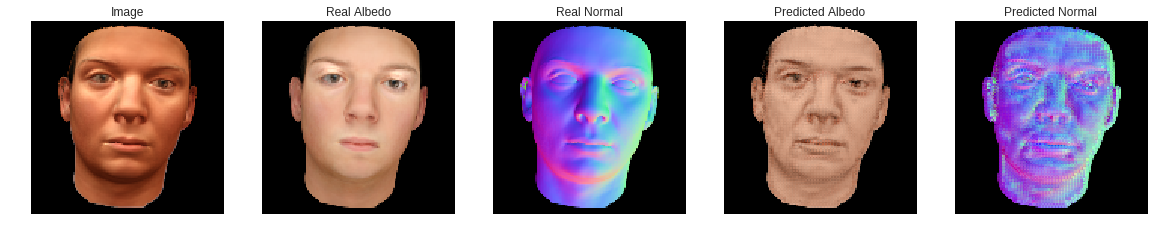

In [0]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,5,figsize=(20,5))

img = test_image
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Image')

img = test_data["albedos"][0]
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title('Real Albedo')

img = test_data["normals"][0]
axs[2].imshow(img)
axs[2].axis('off')
axs[2].set_title('Real Normal')

img = predicted_albedo
axs[3].imshow(img)
axs[3].axis('off')
axs[3].set_title('Predicted Albedo')

img = predicted_normal
axs[4].imshow(img)
axs[4].axis('off')
axs[4].set_title('Predicted Normal')